In [5]:
import seaborn as sns
import pandas as pd
import os
import numpy as np
import math
from math import cos, sin, tanh

In [ ]:
#Separating relavent and inrevelant part of the data from the raw txt files.

#--- Insert here ---
pp_id = '09'
position_of = 'Human'
run = True
#-------------------

if run == True:
    # Define input and output file path
    rawfile = open('/Users/nanap/My project/Assets/TrackerData/'+ pp_id + position_of +'_position.txt', 'r')
    Lines = rawfile.readlines()

    path = './newdata/id_' + pp_id + '/' + position_of

    isExist = os.path.exists(path)
    isExist_pp =os.path.exists('./newdata/id_' + pp_id)

    if isExist == False:
        if isExist_pp== False:
            os.mkdir('./newdata/id_' + pp_id)
        os.mkdir(path)

    # Initialize count
    count = 1
    addline = False

    # Read the text file line by line 
    for line in Lines:
        print(line)
        if line == '--- Calibration ---\n':
            print('calibration')

        elif line == '--- Start ' + str(count) + ' ---\n':
            print('START')
            # Create new file with Start 
            newfile = open(path + '/' + pp_id + '_' + str(count) +'.txt', 'w')
            addline = True

        elif line == '--- End ' + str(count) + ' ---\n':
            print("END")
            addline = False
            newfile.close()
            count += 1
        else:    
            if addline==True:
                line = line.replace(",", "") # remove ',' between x and z 
                newfile.write(line) # add valid line to new txt file

            else:
                pass

    rawfile.close()

In [11]:
# Make a function for standard formatting of the dataframe

def format_df(df):
    #df['timestamp'] = pd.to_datetime(df['timestamp'], format = '%H:%M:%S:%f')
    df = df.drop(['timestamp'], axis = 1)
    df['time'] = df.index/10
    df.iloc[:200, :]
    return df

In [2]:
# Transform coordinate 
# idea: even number human start as 0
#       odd number human start as goal 
# return transformation 

def get_transform(pp_id):
    start_x = []
    start_z = []
    goal_x = []
    goal_z = []
    
    # Adjust index (pp 1~10 did fronting first, pp 11~ did crossing first)
    if int(pp_id)<=10 or int(pp_id) == 21:
        init_idx = 0
    else:
        init_idx = 16
    
    for i in range (1,17):
        # Read each file and add start point to the list 
        position_of = 'Human'
        filepath = './newdata/id_' + pp_id + '/' + position_of + '/' + pp_id + '_' + str(init_idx + i) + '.txt'
        df = pd.read_csv(filepath, sep=" ", header=None, names=["timestamp", "x", "z"])
        
        # Check if the motion tracker was not lost 
        if (df.iloc[0]['x'] == df.iloc[1]['x']):
            print("--- Check manually, motion tracker might have been lost ---")
            print(init_idx + i)
            
        else:
            print("pp_id", pp_id)
            print(filepath)
            if i%2 == 0:
                print(df.iloc[0]['x'])
                start_x.append(df.iloc[0]['x'])
                start_z.append(df.iloc[0]['z'])
        
            else: 
                
                goal_x.append(df.iloc[0]['x'])
                goal_z.append(df.iloc[0]['z'])

    print("Start and goal points", start_x, "\n", start_z , "\n", goal_x, "\n", goal_z)  
                
    # Get the start and goal coordinate by averaging the points
    start_coord = (np.mean(start_x), np.mean(start_z))
    goal_coord = (np.mean(goal_x), np.mean(goal_z))
    print("Start coordinate", start_coord)
    print("Goal coordinate", goal_coord)
    
    distance = math.dist(start_coord, goal_coord)
    
    rotation = np.tanh((goal_coord[1]-start_coord[1])/(goal_coord[0]-start_coord[0]) )
    print("original rotation", rotation*180/np.pi)
    if (goal_coord[0]-start_coord[0])<0 and (goal_coord[1]-start_coord[1])>0:
        rotation += np.pi
    elif (goal_coord[0]-start_coord[0])<0 and (goal_coord[1]-start_coord[1])<0:
        rotation += np.pi
#     elif (goal_coord[0]-start_coord[0])<0 and (goal_coord[1]-start_coord[1])<0:
#         rotation += np.pi*3/2
        
    print("distance [m]: ", distance)
    print("rotation [deg]: ", rotation*180/np.pi)

    return start_coord, rotation*(-1)


In [20]:
def apply_transformation(pp_id, start_coord, rotation, position_of):
    
    # Check if the path to save file exists, if not make one
    path = './traj_data/id_' + pp_id + '/' + position_of

    isExist = os.path.exists(path)
    isExist_pp =os.path.exists('./traj_data/id_' + pp_id)

    if isExist == False:
        if isExist_pp== False:
            os.mkdir('./traj_data/id_' + pp_id)
        os.mkdir(path)
    
    ## Transform the human's start point to origin
    # Read each file 
    for i in range(1,33):
        print("--------", i)
        filepath = './newdata/id_' + pp_id + '/' + position_of + '/' + pp_id + '_' + str(i) + '.txt'
        df = pd.read_csv(filepath, sep=" ", header=None, names=["timestamp", "x", "z"])
        
        df['x'] -= start_coord[0]
        df['z'] -= start_coord[1]
        
        # Apply rotation to follow along x axis
        df['x_new'] = cos(rotation)*df['x'] - sin(rotation)*df['z']
        df['z_new'] = sin(rotation)*df['x'] + cos(rotation)*df['z']
        
        # Now, rotate 180 degrees if it's an even number trials, and shift along x axis (= Spot always start from x=0)
        if i%2 == 0:
            shift_x = df['x_new'].mean()
            df['x_new'] -= shift_x
            df['x_new2'] = cos(math.pi)*df['x_new'] - sin(math.pi)*df['z_new'] 
            df['z_new2'] = sin(math.pi)*df['x_new'] + cos(math.pi)*df['z_new']
            df['x_new2'] += shift_x

        else:
            df['x_new2'] = df['x_new']
            df['z_new2'] = df['z_new']
        
        df['x'] = df['x_new2']
        df['z'] = df['z_new2']
        
        # Remove duplicate
        df = df.drop(['x_new', 'z_new', 'x_new2', 'z_new2'], axis = 1)
        
        # Apply formatting before writing out
        df = format_df(df)
        
        # Write it to csv file (traj_data folder for temporal data)
        df.to_csv('./traj_data/id_' + pp_id + '/' + position_of + '/' + pp_id + '_' + str(i) + '.csv')
        
        print(df)

In [12]:
# Transform coordinates for single participant (for debugging)
#---
pp_id = '11'
position_of = 'Human'
#--- 

start_coord, rotation = get_transform(pp_id)
print(start_coord)
apply_transformation(pp_id, start_coord, rotation, position_of)


--- Check manually, motion tracker might have been lost ---
17
pp_id 11
./newdata/id_11/Human/11_18.txt
1.412648
pp_id 11
./newdata/id_11/Human/11_19.txt
pp_id 11
./newdata/id_11/Human/11_20.txt
1.629177
pp_id 11
./newdata/id_11/Human/11_21.txt
pp_id 11
./newdata/id_11/Human/11_22.txt
1.69153
pp_id 11
./newdata/id_11/Human/11_23.txt
pp_id 11
./newdata/id_11/Human/11_24.txt
1.662419
pp_id 11
./newdata/id_11/Human/11_25.txt
pp_id 11
./newdata/id_11/Human/11_26.txt
1.645
pp_id 11
./newdata/id_11/Human/11_27.txt
pp_id 11
./newdata/id_11/Human/11_28.txt
1.626036
pp_id 11
./newdata/id_11/Human/11_29.txt
pp_id 11
./newdata/id_11/Human/11_30.txt
1.661581
pp_id 11
./newdata/id_11/Human/11_31.txt
pp_id 11
./newdata/id_11/Human/11_32.txt
1.659846
Start and goal points [1.412648, 1.629177, 1.69153, 1.662419, 1.645, 1.626036, 1.661581, 1.659846] 
 [-0.03748325, 0.09760862, 0.09541443, 0.007914219, 0.09076517, 0.08355241, -0.04418204, 0.1540397] 
 [-0.6758795, -0.6475825, -0.5414047, -0.5212267, -0.

            x         z  time
0    6.277285  0.017199   0.0
1    6.276425  0.016910   0.1
2    6.275633  0.016431   0.2
3    6.274790  0.016384   0.3
4    6.273673  0.015458   0.4
..        ...       ...   ...
154  0.029492  1.393553  15.4
155  0.028522  1.391848  15.5
156  0.027343  1.390890  15.6
157  0.026329  1.394241  15.7
158  0.025031  1.397818  15.8

[159 rows x 3 columns]
-------- 29
            x         z  time
0    6.267153 -1.433699   0.0
1    6.267047 -1.433689   0.1
2    6.267085 -1.433264   0.2
3    6.267000 -1.433034   0.3
4    6.266960 -1.433253   0.4
..        ...       ...   ...
162 -0.094017  0.010657  16.2
163 -0.094215  0.010585  16.3
164 -0.094987  0.010041  16.4
165 -0.095716  0.009755  16.5
166 -0.096708  0.010435  16.6

[167 rows x 3 columns]
-------- 30
            x         z  time
0    6.406648 -0.022941   0.0
1    6.407144 -0.022836   0.1
2    6.407254 -0.023576   0.2
3    6.407296 -0.023953   0.3
4    6.407068 -0.023985   0.4
..        ...       ...   ..

In [21]:
# Transform coordinate for all participants

pp_ids = ["%02d" % x for x in range(1,22)]
positions_of = ["Human", "Spot"]

for pp_id in pp_ids:
    print("===== ", pp_id , "======", position_of, )
    start_coord, rotation = get_transform(pp_id)
    for name in positions_of:
        apply_transformation(pp_id, start_coord, rotation, name)

=====  01 ======
pp_id 01
./newdata/id_01/Human/01_1.txt
pp_id 01
./newdata/id_01/Human/01_2.txt
-1.303518
pp_id 01
./newdata/id_01/Human/01_3.txt
pp_id 01
./newdata/id_01/Human/01_4.txt
-1.398516
pp_id 01
./newdata/id_01/Human/01_5.txt
pp_id 01
./newdata/id_01/Human/01_6.txt
-1.305082
pp_id 01
./newdata/id_01/Human/01_7.txt
pp_id 01
./newdata/id_01/Human/01_8.txt
-1.277122
pp_id 01
./newdata/id_01/Human/01_9.txt
pp_id 01
./newdata/id_01/Human/01_10.txt
-1.366053
pp_id 01
./newdata/id_01/Human/01_11.txt
pp_id 01
./newdata/id_01/Human/01_12.txt
-1.298823
pp_id 01
./newdata/id_01/Human/01_13.txt
pp_id 01
./newdata/id_01/Human/01_14.txt
-1.353425
pp_id 01
./newdata/id_01/Human/01_15.txt
pp_id 01
./newdata/id_01/Human/01_16.txt
-1.256832
Start and goal points [-1.303518, -1.398516, -1.305082, -1.277122, -1.366053, -1.298823, -1.353425, -1.256832] 
 [0.7134986, 0.6835543, 0.7729976, 0.7778822, 0.8456872, 0.8231413, 0.7141908, 0.7802554] 
 [2.387959, 2.421221, 2.366708, 2.38705, 2.400146, 2.

            x         z  time
0    0.581933  0.181993   0.0
1    0.581929  0.182107   0.1
2    0.586104  0.181275   0.2
3    0.601540  0.178309   0.3
4    0.620109  0.174258   0.4
..        ...       ...   ...
99   5.189653  0.390207   9.9
100  5.234998  0.391614  10.0
101  5.272483  0.391030  10.1
102  5.326950  0.392148  10.2
103  5.380634  0.389440  10.3

[104 rows x 3 columns]
-------- 8
            x         z  time
0    1.906028 -0.292837   0.0
1    1.906074 -0.293190   0.1
2    1.908442 -0.286784   0.2
3    1.911929 -0.277638   0.3
4    1.914850 -0.270690   0.4
..        ...       ...   ...
101  6.563941 -0.152605  10.1
102  6.598075 -0.148593  10.2
103  6.651615 -0.147646  10.3
104  6.708682 -0.148696  10.4
105  6.763297 -0.149732  10.5

[106 rows x 3 columns]
-------- 9
            x         z  time
0    0.555168  0.181421   0.0
1    0.555607  0.181553   0.1
2    0.567365  0.187046   0.2
3    0.594691  0.190379   0.3
4    0.635343  0.198385   0.4
..        ...       ...   ...


            x         z  time
0   -1.599686 -0.525231   0.0
1   -1.599740 -0.525276   0.1
2   -1.596245 -0.522839   0.2
3   -1.592927 -0.515097   0.3
4   -1.573012 -0.509320   0.4
..        ...       ...   ...
197  4.319363  0.018463  19.7
198  4.317310  0.018878  19.8
199  4.315673  0.019816  19.9
200  4.314662  0.021572  20.0
201  4.313497  0.020972  20.1

[202 rows x 3 columns]
-------- 29
            x         z  time
0    0.553490 -0.022119   0.0
1    0.553554 -0.022555   0.1
2    0.552142 -0.019948   0.2
3    0.547754 -0.020769   0.3
4    0.545124 -0.022529   0.4
..        ...       ...   ...
185  6.260956  0.492001  18.5
186  6.260609  0.492242  18.6
187  6.260400  0.491399  18.7
188  6.260182  0.491117  18.8
189  6.259958  0.491865  18.9

[190 rows x 3 columns]
-------- 30
            x         z  time
0    0.858117 -0.493891   0.0
1    0.858210 -0.494927   0.1
2    0.866260 -0.490727   0.2
3    0.886134 -0.483450   0.3
4    0.920244 -0.475943   0.4
..        ...       ...   ..

            x         z  time
0    9.177450  0.013622   0.0
1    9.177263  0.013407   0.1
2    9.176812  0.013492   0.2
3    9.176598  0.012774   0.3
4    9.176887  0.012672   0.4
..        ...       ...   ...
192  2.696023  0.147500  19.2
193  2.695969  0.147595  19.3
194  2.696158  0.147477  19.4
195  2.696855  0.147673  19.5
196  2.697522  0.147036  19.6

[197 rows x 3 columns]
-------- 15
            x         z  time
0    6.453352 -0.214675   0.0
1    6.453197 -0.214220   0.1
2    6.455530 -0.230958   0.2
3    6.457609 -0.232015   0.3
4    6.459878 -0.231361   0.4
..        ...       ...   ...
158  0.011857  0.010488  15.8
159  0.011401  0.010660  15.9
160  0.011029  0.010620  16.0
161  0.010417  0.010585  16.1
162 -0.006188 -0.005446  16.2

[163 rows x 3 columns]
-------- 16
            x         z  time
0    9.223224  0.010154   0.0
1    9.223111  0.010368   0.1
2    9.222558  0.009536   0.2
3    9.222176  0.008819   0.3
4    9.222344  0.008285   0.4
..        ...       ...   ..

            x         z  time
0    0.155587  0.149202   0.0
1    0.155150  0.149049   0.1
2    0.153164  0.147188   0.2
3    0.151575  0.146928   0.3
4    0.149463  0.148184   0.4
..        ...       ...   ...
192  5.673600  0.225988  19.2
193  5.740553  0.205797  19.3
194  5.839677  0.178779  19.4
195  5.932478  0.153410  19.5
196  6.017080  0.131034  19.6

[197 rows x 3 columns]
-------- 15
            x         z  time
0    0.159918  0.006433   0.0
1    0.159913  0.006293   0.1
2    0.167177  0.010390   0.2
3    0.189797  0.019874   0.3
4    0.226921  0.027452   0.4
..        ...       ...   ...
158  6.221488  0.011964  15.8
159  6.221095  0.015639  15.9
160  6.221358  0.012583  16.0
161  6.220824  0.011958  16.1
162  6.205306  0.011980  16.2

[163 rows x 3 columns]
-------- 16
            x         z  time
0    0.278873  0.206677   0.0
1    0.279091  0.207352   0.1
2    0.279145  0.205955   0.2
3    0.276592  0.203269   0.3
4    0.272575  0.201463   0.4
..        ...       ...   ..

            x         z  time
0    6.138089  0.364112   0.0
1    6.137439  0.363834   0.1
2    6.137194  0.363490   0.2
3    6.136758  0.363031   0.3
4    6.136512  0.362856   0.4
..        ...       ...   ...
124  0.025478  0.053501  12.4
125  0.024916  0.051842  12.5
126  0.032952  0.038887  12.6
127  0.045029  0.016740  12.7
128  0.052057 -0.000239  12.8

[129 rows x 3 columns]
-------- 12
            x         z  time
0    6.460078 -0.000770   0.0
1    6.460350  0.000239   0.1
2    6.460576  0.000405   0.2
3    6.460838  0.001640   0.3
4    6.460924  0.002708   0.4
..        ...       ...   ...
122  0.328086 -0.414517  12.2
123  0.328708 -0.410495  12.3
124  0.329835 -0.401746  12.4
125  0.333859 -0.395206  12.5
126  0.336379 -0.390582  12.6

[127 rows x 3 columns]
-------- 13
            x         z  time
0    6.150592  0.368326   0.0
1    6.151856  0.367874   0.1
2    6.153005  0.367428   0.2
3    6.153843  0.367193   0.3
4    6.154168  0.367249   0.4
..        ...       ...   ..

            x         z  time
0   -0.862310 -0.210719   0.0
1   -0.862475 -0.211168   0.1
2   -0.863974 -0.211565   0.2
3   -0.865833 -0.211997   0.3
4   -0.868574 -0.213471   0.4
..        ...       ...   ...
176  5.025686 -0.031975  17.6
177  5.024023 -0.035788  17.7
178  5.017159 -0.054945  17.8
179  5.016775 -0.071009  17.9
180  5.024188 -0.103719  18.0

[181 rows x 3 columns]
-------- 17
            x         z  time
0    0.324006  0.133987   0.0
1    0.324085  0.136490   0.1
2    0.323103  0.137883   0.2
3    0.320849  0.138742   0.3
4    0.319859  0.137395   0.4
..        ...       ...   ...
291  5.948009  0.479148  29.1
292  5.940185  0.460632  29.2
293  5.938389  0.443691  29.3
294  5.936705  0.433372  29.4
295  5.933191  0.430761  29.5

[296 rows x 3 columns]
-------- 18
            x         z  time
0   -1.958951 -0.439749   0.0
1   -1.959171 -0.440326   0.1
2   -1.960463 -0.441499   0.2
3   -1.962192 -0.441291   0.3
4   -1.963582 -0.441002   0.4
..        ...       ...   ..

            x         z  time
0    6.360052  0.463938   0.0
1    6.359364  0.470946   0.1
2    6.350952  0.480420   0.2
3    6.323505  0.481697   0.3
4    6.282580  0.477536   0.4
..        ...       ...   ...
248  0.070480 -0.021164  24.8
249  0.071752 -0.023525  24.9
250  0.072832 -0.024745  25.0
251  0.073452 -0.025012  25.1
252  0.073972 -0.025141  25.2

[253 rows x 3 columns]
-------- 16
            x         z  time
0    7.862313  0.029198   0.0
1    7.860841  0.029714   0.1
2    7.859101  0.029189   0.2
3    7.857565  0.028696   0.3
4    7.856789  0.029645   0.4
..        ...       ...   ...
103  1.530210 -0.349535  10.3
104  1.531608 -0.349967  10.4
105  1.532305 -0.346974  10.5
106  1.531665 -0.341465  10.6
107  1.531684 -0.338017  10.7

[108 rows x 3 columns]
-------- 17
            x         z  time
0    3.442474 -2.330957   0.0
1    3.442561 -2.330768   0.1
2    3.442720 -2.330492   0.2
3    3.442799 -2.330287   0.3
4    3.442702 -2.330778   0.4
..        ...       ...   ..

            x         z  time
0    0.249371 -0.070991   0.0
1    0.249246 -0.071095   0.1
2    0.249294 -0.070946   0.2
3    0.255811 -0.069029   0.3
4    0.272811 -0.061538   0.4
..        ...       ...   ...
132  6.222235  0.320566  13.2
133  6.250407  0.330783  13.3
134  6.271165  0.339174  13.4
135  6.278421  0.343548  13.5
136  6.281901  0.341598  13.6

[137 rows x 3 columns]
-------- 22
            x         z  time
0    0.836488 -0.451611   0.0
1    0.836493 -0.451703   0.1
2    0.835910 -0.452309   0.2
3    0.832133 -0.452836   0.3
4    0.828412 -0.452842   0.4
..        ...       ...   ...
123  6.432124 -0.406376  12.3
124  6.389061 -0.435534  12.4
125  6.479515 -0.415909  12.5
126  6.504941 -0.423416  12.6
127  6.564985 -0.415544  12.7

[128 rows x 3 columns]
-------- 23
            x         z  time
0    0.371659  0.457515   0.0
1    0.371659  0.457515   0.1
2    0.388280 -0.072127   0.2
3    0.386335 -0.071656   0.3
4    0.384452 -0.067953   0.4
..        ...       ...   ..

            x         z  time
0    6.557979  0.213386   0.0
1    6.558962  0.213745   0.1
2    6.559259  0.215175   0.2
3    6.559189  0.216969   0.3
4    6.559060  0.218459   0.4
..        ...       ...   ...
187 -0.160396  0.030487  18.7
188 -0.160899  0.031824  18.8
189 -0.161734  0.033085  18.9
190 -0.162359  0.034033  19.0
191 -0.162416  0.033140  19.1

[192 rows x 3 columns]
-------- 8
            x         z  time
0    8.333636 -0.013916   0.0
1    8.331192 -0.014307   0.1
2    8.329903 -0.014881   0.2
3    8.327725 -0.015489   0.3
4    8.326761 -0.016048   0.4
..        ...       ...   ...
154  1.679270 -0.158741  15.4
155  1.685839 -0.156393  15.5
156  1.690654 -0.156892  15.6
157  1.694259 -0.159421  15.7
158  1.698606 -0.166100  15.8

[159 rows x 3 columns]
-------- 9
            x         z  time
0    6.522322  0.472269   0.0
1    6.520070  0.484133   0.1
2    6.518309  0.488277   0.2
3    6.516997  0.484213   0.3
4    6.516423  0.476539   0.4
..        ...       ...   ...


            x         z  time
0   -2.268876 -0.466720   0.0
1   -2.268903 -0.466615   0.1
2   -2.261519 -0.462923   0.2
3   -2.240820 -0.452367   0.3
4   -2.206003 -0.436449   0.4
..        ...       ...   ...
263  3.513560  0.002285  26.3
264  3.513496  0.002377  26.4
265  3.513382  0.001975  26.5
266  3.513395  0.002623  26.6
267  3.513441  0.002637  26.7

[268 rows x 3 columns]
-------- 13
            x         z  time
0    0.214108 -0.004263   0.0
1    0.214225 -0.004244   0.1
2    0.214551 -0.004084   0.2
3    0.224509 -0.007591   0.3
4    0.248799 -0.010765   0.4
..        ...       ...   ...
177  6.088643  0.640961  17.7
178  6.070243  0.623547  17.8
179  6.049319  0.604406  17.9
180  6.025178  0.590631  18.0
181  6.002304  0.581158  18.1

[182 rows x 3 columns]
-------- 14
            x         z  time
0   -0.922076 -0.329193   0.0
1   -0.922273 -0.329026   0.1
2   -0.922370 -0.329502   0.2
3   -0.925114 -0.330427   0.3
4   -0.929375 -0.333560   0.4
..        ...       ...   ..

            x         z  time
0    9.552356  0.025401   0.0
1    9.551459  0.026754   0.1
2    9.550540  0.027136   0.2
3    9.549808  0.027625   0.3
4    9.549546  0.028230   0.4
..        ...       ...   ...
171  3.219391 -1.010622  17.1
172  3.219509 -1.010035  17.2
173  3.219313 -1.009775  17.3
174  3.219472 -1.009956  17.4
175  3.219467 -1.008880  17.5

[176 rows x 3 columns]
-------- 15
            x         z  time
0    6.328317  1.010859   0.0
1    6.325364  1.010541   0.1
2    6.323705  1.011123   0.2
3    6.323420  1.013315   0.3
4    6.323594  1.015220   0.4
..        ...       ...   ...
161  0.014457  0.006115  16.1
162  0.015504  0.006006  16.2
163  0.016646  0.005028  16.3
164  0.017428  0.005747  16.4
165  0.018989  0.004468  16.5

[166 rows x 3 columns]
-------- 16
            x         z  time
0    9.719303 -0.010761   0.0
1    9.719644 -0.010128   0.1
2    9.720236 -0.010268   0.2
3    9.720802 -0.010404   0.3
4    9.721500 -0.010360   0.4
..        ...       ...   ..

            x         z  time
0    0.163684  0.056172   0.0
1    0.163581  0.056611   0.1
2    0.162523  0.054417   0.2
3    0.160775  0.052670   0.3
4    0.159160  0.054147   0.4
..        ...       ...   ...
199  6.070392  1.095518  19.9
200  6.113105  1.099550  20.0
201  6.146616  1.092313  20.1
202  6.190825  1.070182  20.2
203  6.233099  1.045806  20.3

[204 rows x 3 columns]
-------- 14
            x         z  time
0   -0.846258 -1.059582   0.0
1   -0.846200 -1.060222   0.1
2   -0.843411 -1.055389   0.2
3   -0.825639 -1.041955   0.3
4   -0.794733 -1.029076   0.4
..        ...       ...   ...
171  5.077177  0.213664  17.1
172  5.068279  0.212763  17.2
173  5.058042  0.214957  17.3
174  5.051927  0.213714  17.4
175  5.045548  0.213809  17.5

[176 rows x 3 columns]
-------- 15
            x         z  time
0    0.025921  0.055989   0.0
1    0.026008  0.056152   0.1
2    0.033475  0.057125   0.2
3    0.044478  0.064078   0.3
4    0.075250  0.075809   0.4
..        ...       ...   ..

            x         z  time
0    6.370088 -0.236467   0.0
1    6.367181 -0.237048   0.1
2    6.364671 -0.241847   0.2
3    6.359860 -0.249519   0.3
4    6.353766 -0.261016   0.4
..        ...       ...   ...
242  0.026554 -0.081731  24.2
243  0.026861 -0.085669  24.3
244  0.029297 -0.086138  24.4
245  0.027111 -0.084120  24.5
246  0.026914 -0.084004  24.6

[247 rows x 3 columns]
-------- 4
            x         z  time
0    7.472524  0.056781   0.0
1    7.471529  0.057211   0.1
2    7.469929  0.058534   0.2
3    7.467623  0.060565   0.3
4    7.465860  0.061580   0.4
..        ...       ...   ...
153  1.125316  0.273018  15.3
154  1.123304  0.271801  15.4
155  1.121418  0.270970  15.5
156  1.118390  0.271666  15.6
157  1.115607  0.272823  15.7

[158 rows x 3 columns]
-------- 5
            x         z  time
0    6.406754 -0.283764   0.0
1    6.404891 -0.281593   0.1
2    6.402961 -0.280151   0.2
3    6.402477 -0.279398   0.3
4    6.401975 -0.278905   0.4
..        ...       ...   ...


            x         z  time
0    0.511633  0.121289   0.0
1    0.511717  0.120322   0.1
2    0.510728  0.119239   0.2
3    0.509076  0.118800   0.3
4    0.507886  0.119025   0.4
..        ...       ...   ...
242  6.166988 -0.170143  24.2
243  6.176703 -0.194298  24.3
244  6.182136 -0.219955  24.4
245  6.193785 -0.237442  24.5
246  6.212816 -0.242193  24.6

[247 rows x 3 columns]
-------- 4
            x         z  time
0   -0.161387  0.380441   0.0
1   -0.159256  0.380867   0.1
2   -0.145987  0.385165   0.2
3   -0.117260  0.389318   0.3
4   -0.094671  0.392424   0.4
..        ...       ...   ...
153  5.711253 -0.241125  15.3
154  5.706197 -0.234192  15.4
155  5.700488 -0.235001  15.5
156  5.702256 -0.219108  15.6
157  5.701269 -0.236379  15.7

[158 rows x 3 columns]
-------- 5
            x         z  time
0    0.302037  0.142284   0.0
1    0.301460  0.140086   0.1
2    0.301381  0.140090   0.2
3    0.298198  0.140845   0.3
4    0.293449  0.139344   0.4
..        ...       ...   ...


            x         z  time
0    8.496656  0.011866   0.0
1    8.496403  0.012135   0.1
2    8.496069  0.012157   0.2
3    8.495060  0.012169   0.3
4    8.493226  0.011997   0.4
..        ...       ...   ...
171  2.070685  0.331987  17.1
172  2.070513  0.330984  17.2
173  2.070414  0.330185  17.3
174  2.070371  0.329754  17.4
175  2.070352  0.329365  17.5

[176 rows x 3 columns]
-------- 9
            x         z  time
0    6.385496 -0.321349   0.0
1    6.386465 -0.322236   0.1
2    6.387297 -0.321270   0.2
3    6.386845 -0.321120   0.3
4    6.385212 -0.321458   0.4
..        ...       ...   ...
170 -0.009757 -0.015543  17.0
171 -0.008637 -0.016672  17.1
172 -0.007279 -0.016933  17.2
173 -0.006477 -0.015830  17.3
174 -0.006698 -0.014980  17.4

[175 rows x 3 columns]
-------- 10
            x         z  time
0    8.331799  0.012356   0.0
1    8.331839  0.011426   0.1
2    8.332357  0.011446   0.2
3    8.332243  0.011821   0.3
4    8.331690  0.011516   0.4
..        ...       ...   ...

            x         z  time
0   -0.176452  0.430891   0.0
1   -0.176491  0.430187   0.1
2   -0.177579  0.429808   0.2
3   -0.180002  0.430019   0.3
4   -0.184872  0.432473   0.4
..        ...       ...   ...
220  5.591246 -0.363830  22.0
221  5.582951 -0.360457  22.1
222  5.573482 -0.356312  22.2
223  5.568246 -0.354509  22.3
224  5.570396 -0.355177  22.4

[225 rows x 3 columns]
-------- 17
            x         z  time
0    1.019614  0.073119   0.0
1    1.019614  0.073119   0.1
2    1.019614  0.073119   0.2
3    1.019614  0.073119   0.3
4    1.019614  0.073119   0.4
..        ...       ...   ...
122  6.294292 -0.140588  12.2
123  6.304844 -0.140158  12.3
124  6.312098 -0.142431  12.4
125  6.319804 -0.145867  12.5
126  6.323690 -0.147962  12.6

[127 rows x 3 columns]
-------- 18
            x         z  time
0   -1.180294  0.265507   0.0
1   -1.180515  0.266156   0.1
2   -1.177741  0.273464   0.2
3   -1.171359  0.276727   0.3
4   -1.153823  0.296113   0.4
..        ...       ...   ..

            x         z  time
0    3.221648  2.791915   0.0
1    3.225009  2.790827   0.1
2    3.225695  2.790525   0.2
3    3.229565  2.789523   0.3
4    3.226312  2.790102   0.4
..        ...       ...   ...
152  3.429197 -2.291279  15.2
153  3.429197 -2.291279  15.3
154  3.429197 -2.291279  15.4
155  3.429197 -2.291279  15.5
156  3.429197 -2.291279  15.6

[157 rows x 3 columns]
-------- 22
            x         z  time
0    3.033444  2.291279   0.0
1    3.033444  2.291279   0.1
2    3.033444  2.291279   0.2
3    3.033444  2.291279   0.3
4    3.033444  2.291279   0.4
..        ...       ...   ...
147  3.332021 -2.781279  14.7
148  3.323859 -2.779629  14.8
149  3.318277 -2.778433  14.9
150  3.312972 -2.777572  15.0
151  3.309336 -2.776974  15.1

[152 rows x 3 columns]
-------- 23
            x         z  time
0    3.097625  2.806056   0.0
1    3.093800  2.804618   0.1
2    3.090152  2.803427   0.2
3    3.086112  2.802461   0.3
4    3.087330  2.800846   0.4
..        ...       ...   ..

            x         z  time
0    0.351747  0.102380   0.0
1    0.358952  0.107528   0.1
2    0.374656  0.103647   0.2
3    0.408782  0.110156   0.3
4    0.449948  0.119140   0.4
..        ...       ...   ...
169  6.433273  0.044243  16.9
170  6.435097  0.041893  17.0
171  6.436281  0.039831  17.1
172  6.437284  0.038345  17.2
173  6.438131  0.036620  17.3

[174 rows x 3 columns]
-------- 30
            x         z  time
0   -0.121426 -0.212358   0.0
1   -0.119498 -0.211585   0.1
2   -0.112448 -0.207070   0.2
3   -0.093542 -0.195138   0.3
4   -0.060449 -0.187471   0.4
..        ...       ...   ...
146  5.998440 -0.148523  14.6
147  6.006795 -0.154990  14.7
148  5.998591 -0.158357  14.8
149  5.990766 -0.160873  14.9
150  6.006541 -0.167427  15.0

[151 rows x 3 columns]
-------- 31
            x         z  time
0    2.302298  0.853927   0.0
1    2.302298  0.853927   0.1
2    2.302298  0.853927   0.2
3    2.302298  0.853927   0.3
4    2.302298  0.853927   0.4
..        ...       ...   ..

            x         z  time
0    6.312137  0.109975   0.0
1    6.315856  0.109349   0.1
2    6.316257  0.108521   0.2
3    6.315585  0.108084   0.3
4    6.313183  0.107459   0.4
..        ...       ...   ...
184 -0.065304  0.001571  18.4
185 -0.065295  0.001952  18.5
186 -0.065463  0.002075  18.6
187 -0.065338  0.001662  18.7
188 -0.065213  0.000995  18.8

[189 rows x 3 columns]
-------- 16
            x         z  time
0    9.357608 -0.001457   0.0
1    9.357020 -0.001468   0.1
2    9.356119 -0.001949   0.2
3    9.355674 -0.002725   0.3
4    9.355298 -0.004069   0.4
..        ...       ...   ...
155  2.973551 -0.101264  15.5
156  2.975697 -0.099994  15.6
157  2.977885 -0.099411  15.7
158  2.979856 -0.098623  15.8
159  2.981798 -0.098933  15.9

[160 rows x 3 columns]
-------- 17
            x         z  time
0    3.154988 -2.357202   0.0
1    3.159403 -2.342510   0.1
2    3.163798 -2.330412   0.2
3    3.170240 -2.306865   0.3
4    3.173777 -2.265175   0.4
..        ...       ...   ..

            x         z  time
0    0.160039  0.024299   0.0
1    0.159924  0.023981   0.1
2    0.159829  0.024588   0.2
3    0.159028  0.024842   0.3
4    0.157144  0.024480   0.4
..        ...       ...   ...
184  5.988498  0.419880  18.4
185  5.992612  0.419726  18.5
186  5.994842  0.419552  18.6
187  5.995750  0.419039  18.7
188  5.995616  0.418855  18.8

[189 rows x 3 columns]
-------- 16
            x         z  time
0   -0.687021 -0.022627   0.0
1   -0.687185 -0.022468   0.1
2   -0.683888 -0.026802   0.2
3   -0.673890 -0.020796   0.3
4   -0.663699 -0.006079   0.4
..        ...       ...   ...
155  5.124813 -0.165206  15.5
156  5.122789 -0.163219  15.6
157  5.123010 -0.161696  15.7
158  5.123205 -0.163452  15.8
159  5.124071 -0.161485  15.9

[160 rows x 3 columns]
-------- 17
            x         z  time
0    0.230637  0.078476   0.0
1    0.230581  0.078256   0.1
2    0.230455  0.077892   0.2
3    0.229851  0.077807   0.3
4    0.225698  0.077293   0.4
..        ...       ...   ..

            x         z  time
0    3.788804  1.913605   0.0
1    3.787232  1.910739   0.1
2    3.784351  1.908314   0.2
3    3.782275  1.906346   0.3
4    3.776810  1.902915   0.4
..        ...       ...   ...
140  2.485145 -3.279892  14.0
141  2.487958 -3.277986  14.1
142  2.489982 -3.276473  14.2
143  2.495657 -3.276753  14.3
144  2.502141 -3.279517  14.4

[145 rows x 3 columns]
-------- 16
            x         z  time
0    4.534925  3.247821   0.0
1    4.531233  3.246997   0.1
2    4.528747  3.246478   0.2
3    4.527117  3.246900   0.3
4    4.525829  3.246850   0.4
..        ...       ...   ...
167  3.198429 -1.976370  16.7
168  3.199269 -1.978216  16.8
169  3.198673 -1.980130  16.9
170  3.200012 -1.982172  17.0
171  3.200225 -1.983342  17.1

[172 rows x 3 columns]
-------- 17
            x         z  time
0    6.234274 -1.526905   0.0
1    6.234274 -1.526905   0.1
2    6.234274 -1.526905   0.2
3    6.234274 -1.526905   0.3
4    6.234274 -1.526905   0.4
..        ...       ...   ..

            x         z  time
0    0.656969 -0.062392   0.0
1    0.659427 -0.059658   0.1
2    0.660757 -0.058016   0.2
3    0.659932 -0.055652   0.3
4    0.655669 -0.053861   0.4
..        ...       ...   ...
180  6.276413 -1.684996  18.0
181  6.276475 -1.684670  18.1
182  6.276487 -1.684635  18.2
183  6.276518 -1.684686  18.3
184  6.276502 -1.684166  18.4

[185 rows x 3 columns]
-------- 14
            x         z  time
0   -0.281068  1.630130   0.0
1   -0.279037  1.629888   0.1
2   -0.270059  1.629363   0.2
3   -0.253311  1.631112   0.3
4   -0.219196  1.625548   0.4
..        ...       ...   ...
138  5.736099 -0.088588  13.8
139  5.714520 -0.078533  13.9
140  5.690717 -0.066756  14.0
141  5.703467 -0.074212  14.1
142  5.740117 -0.094474  14.2

[143 rows x 3 columns]
-------- 15
            x         z  time
0    0.550127  0.073525   0.0
1    0.549840  0.072942   0.1
2    0.551703  0.072662   0.2
3    0.556441  0.068370   0.3
4    0.572091  0.061100   0.4
..        ...       ...   ..

            x         z  time
0    2.713847 -1.452851   0.0
1    2.713784 -1.453168   0.1
2    2.711629 -1.452960   0.2
3    2.710915 -1.453051   0.3
4    2.710815 -1.452609   0.4
..        ...       ...   ...
147  4.043190  3.298468  14.7
148  4.047384  3.296970  14.8
149  4.054996  3.295015  14.9
150  4.062332  3.293462  15.0
151  4.073540  3.290530  15.1

[152 rows x 3 columns]
-------- 17
            x         z  time
0    6.600735 -1.772595   0.0
1    6.599779 -1.770985   0.1
2    6.596550 -1.769770   0.2
3    6.594472 -1.768089   0.3
4    6.592946 -1.761544   0.4
..        ...       ...   ...
149  0.195569 -0.035455  14.9
150  0.196536 -0.036563  15.0
151  0.198267 -0.037667  15.1
152  0.199200 -0.039014  15.2
153  0.199396 -0.038485  15.3

[154 rows x 3 columns]
-------- 18
            x         z  time
0    7.237023 -0.027839   0.0
1    7.235616 -0.030004   0.1
2    7.234011 -0.030454   0.2
3    7.233248 -0.028468   0.3
4    7.229293 -0.024284   0.4
..        ...       ...   ..

            x         z  time
0    0.559941 -0.108682   0.0
1    0.560230 -0.108347   0.1
2    0.563834 -0.109320   0.2
3    0.578562 -0.106922   0.3
4    0.611358 -0.108752   0.4
..        ...       ...   ...
158  6.337831 -1.897134  15.8
159  6.337965 -1.897383  15.9
160  6.337617 -1.896917  16.0
161  6.337438 -1.896657  16.1
162  6.337737 -1.896771  16.2

[163 rows x 3 columns]
-------- 24
            x         z  time
0   -0.436331  1.682089   0.0
1   -0.436341  1.681473   0.1
2   -0.429784  1.685507   0.2
3   -0.413829  1.687187   0.3
4   -0.380530  1.677745   0.4
..        ...       ...   ...
151  5.278536 -0.314252  15.1
152  5.278323 -0.315275  15.2
153  5.274919 -0.315221  15.3
154  5.277317 -0.314743  15.4
155  5.293914 -0.314022  15.5

[156 rows x 3 columns]
-------- 25
            x         z  time
0    0.579200 -0.106866   0.0
1    0.579145 -0.105339   0.1
2    0.577669 -0.103819   0.2
3    0.572950 -0.102990   0.3
4    0.571072 -0.102144   0.4
..        ...       ...   ..

            x         z  time
0    6.337486 -1.661445   0.0
1    6.342638 -1.660331   0.1
2    6.346068 -1.655433   0.2
3    6.348942 -1.644707   0.3
4    6.352500 -1.631510   0.4
..        ...       ...   ...
184 -0.022752 -0.095122  18.4
185 -0.022968 -0.096290  18.5
186 -0.023008 -0.095937  18.6
187 -0.023411 -0.095427  18.7
188 -0.024204 -0.094460  18.8

[189 rows x 3 columns]
-------- 26
            x         z  time
0    8.230277  0.114261   0.0
1    8.230614  0.115035   0.1
2    8.231587  0.116322   0.2
3    8.232512  0.116823   0.3
4    8.232663  0.117128   0.4
..        ...       ...   ...
171  1.997721  1.477926  17.1
172  1.997138  1.477291  17.2
173  1.996029  1.475734  17.3
174  1.995296  1.474419  17.4
175  1.994367  1.473630  17.5

[176 rows x 3 columns]
-------- 27
            x         z  time
0    6.217404 -1.554710   0.0
1    6.214499 -1.550807   0.1
2    6.211879 -1.548590   0.2
3    6.210819 -1.546674   0.3
4    6.210248 -1.545843   0.4
..        ...       ...   ..

            x         z  time
0    0.507909 -0.107950   0.0
1    0.507931 -0.107964   0.1
2    0.504671 -0.105353   0.2
3    0.500928 -0.104495   0.3
4    0.497948 -0.104399   0.4
..        ...       ...   ...
145  6.145530 -1.738457  14.5
146  6.144451 -1.740594  14.6
147  6.143367 -1.745762  14.7
148  6.141635 -1.748564  14.8
149  6.140120 -1.753400  14.9

[150 rows x 3 columns]
-------- 16
            x         z  time
0    0.085276  1.548803   0.0
1    0.085534  1.549230   0.1
2    0.090582  1.551007   0.2
3    0.112590  1.555904   0.3
4    0.147345  1.545597   0.4
..        ...       ...   ...
145  5.704625 -0.523108  14.5
146  5.709895 -0.525260  14.6
147  5.713990 -0.519697  14.7
148  5.713990 -0.519697  14.8
149  5.713990 -0.519697  14.9

[150 rows x 3 columns]
-------- 17
            x         z  time
0    0.379272 -0.065189   0.0
1    0.383393 -0.059781   0.1
2    0.391923 -0.047187   0.2
3    0.396240 -0.070638   0.3
4    0.405223 -0.089450   0.4
..        ...       ...   ..

            x         z  time
0    3.415708 -2.954585   0.0
1    3.415078 -2.955236   0.1
2    3.415206 -2.955201   0.2
3    3.416088 -2.954815   0.3
4    3.416172 -2.953675   0.4
..        ...       ...   ...
130  3.047093  2.346302  13.0
131  3.043059  2.350341  13.1
132  3.040798  2.353049  13.2
133  3.041467  2.354096  13.3
134  3.048252  2.353239  13.4

[135 rows x 3 columns]
-------- 3
            x         z  time
0    3.315366 -2.311105   0.0
1    3.310875 -2.310980   0.1
2    3.304697 -2.310036   0.2
3    3.299813 -2.310311   0.3
4    3.295046 -2.310411   0.4
..        ...       ...   ...
160  3.071919  2.581372  16.0
161  3.071193  2.576963  16.1
162  3.044078  2.576375  16.2
163  3.054667  2.574388  16.3
164  3.062747  2.573668  16.4

[165 rows x 3 columns]
-------- 4
            x         z  time
0    3.286138 -2.767617   0.0
1    3.285561 -2.769029   0.1
2    3.285536 -2.770047   0.2
3    3.286504 -2.770734   0.3
4    3.286532 -2.771701   0.4
..        ...       ...   ...


            x         z  time
0    0.185044 -0.350933   0.0
1    0.185537 -0.351315   0.1
2    0.193145 -0.351470   0.2
3    0.208699 -0.347469   0.3
4    0.241098 -0.353771   0.4
..        ...       ...   ...
163  6.072292 -0.269704  16.3
164  6.071859 -0.271285  16.4
165  6.071782 -0.271688  16.5
166  6.071201 -0.272484  16.6
167  6.070215 -0.271137  16.7

[168 rows x 3 columns]
-------- 11
            x         z  time
0    0.272388  0.121241   0.0
1    0.272206  0.121576   0.1
2    0.271358  0.121516   0.2
3    0.268214  0.120029   0.3
4    0.264059  0.120630   0.4
..        ...       ...   ...
145  6.162072  0.455026  14.5
146  6.163014  0.454433  14.6
147  6.163522  0.455070  14.7
148  6.163869  0.454492  14.8
149  6.164002  0.455129  14.9

[150 rows x 3 columns]
-------- 12
            x         z  time
0   -1.252865 -0.438628   0.0
1   -1.252763 -0.439121   0.1
2   -1.244385 -0.436056   0.2
3   -1.220864 -0.433971   0.3
4   -1.181481 -0.427575   0.4
..        ...       ...   ..

            x         z  time
0    0.315085  0.113227   0.0
1    0.315128  0.113014   0.1
2    0.314026  0.113649   0.2
3    0.312101  0.113872   0.3
4    0.310021  0.113659   0.4
..        ...       ...   ...
235  6.149826  0.619322  23.5
236  6.148306  0.619046  23.6
237  6.148209  0.618538  23.7
238  6.147534  0.618766  23.8
239  6.147833  0.618263  23.9

[240 rows x 3 columns]
-------- 32
            x         z  time
0   -0.716876 -0.420740   0.0
1   -0.716853 -0.421214   0.1
2   -0.716483 -0.422388   0.2
3   -0.704430 -0.423181   0.3
4   -0.679922 -0.426301   0.4
..        ...       ...   ...
171  5.301868 -0.180336  17.1
172  5.301770 -0.179736  17.2
173  5.302113 -0.179903  17.3
174  5.302118 -0.180327  17.4
175  5.302119 -0.179873  17.5

[176 rows x 3 columns]
=====  15 ======
pp_id 15
./newdata/id_15/Human/15_17.txt
--- Check manually, motion tracker might have been lost ---
18
pp_id 15
./newdata/id_15/Human/15_19.txt
--- Check manually, motion tracker might have been lost --

            x         z  time
0    7.999987  0.106158   0.0
1    7.997828  0.105742   0.1
2    7.995136  0.104482   0.2
3    7.996864  0.116563   0.3
4    7.996550  0.119833   0.4
..        ...       ...   ...
150  1.474089 -0.082632  15.0
151  1.470335 -0.083478  15.1
152  1.462807 -0.085891  15.2
153  1.459680 -0.087392  15.3
154  1.456384 -0.088782  15.4

[155 rows x 3 columns]
-------- 27
            x         z  time
0    6.525352 -0.056856   0.0
1    6.526022 -0.055329   0.1
2    6.528485 -0.057028   0.2
3    6.528758 -0.055044   0.3
4    6.528857 -0.056223   0.4
..        ...       ...   ...
181  0.002519  0.127952  18.1
182  0.001862  0.130518  18.2
183  0.000887  0.133020  18.3
184  0.000623  0.135503  18.4
185 -0.000070  0.138339  18.5

[186 rows x 3 columns]
-------- 28
            x         z  time
0    7.339207 -0.081479   0.0
1    7.340668 -0.084722   0.1
2    7.342730 -0.088134   0.2
3    7.343866 -0.089995   0.3
4    7.344543 -0.092677   0.4
..        ...       ...   ..

            x         z  time
0    0.169767 -0.150405   0.0
1    0.169519 -0.150204   0.1
2    0.176397 -0.147471   0.2
3    0.195161 -0.126774   0.3
4    0.227204 -0.108135   0.4
..        ...       ...   ...
155  6.189121  0.190879  15.5
156  6.190197  0.195404  15.6
157  6.189836  0.197667  15.7
158  6.189582  0.198778  15.8
159  6.189284  0.198412  15.9

[160 rows x 3 columns]
-------- 26
            x         z  time
0   -0.133294 -0.000678   0.0
1   -0.133510 -0.001009   0.1
2   -0.136624 -0.001285   0.2
3   -0.141215 -0.000472   0.3
4   -0.142824 -0.000692   0.4
..        ...       ...   ...
150  5.702124  0.130586  15.0
151  5.701805  0.128854  15.1
152  5.701463  0.128211  15.2
153  5.701366  0.126958  15.3
154  5.701088  0.124881  15.4

[155 rows x 3 columns]
-------- 27
            x         z  time
0    0.207835 -0.041728   0.0
1    0.207816 -0.041466   0.1
2    0.207224 -0.039535   0.2
3    0.205830 -0.037682   0.3
4    0.203759 -0.037828   0.4
..        ...       ...   ..

            x         z  time
0    6.380904  0.061298   0.0
1    6.381377  0.060406   0.1
2    6.381355  0.059734   0.2
3    6.381277  0.059108   0.3
4    6.381125  0.058841   0.4
..        ...       ...   ...
152  0.086174 -0.040631  15.2
153  0.086508 -0.040853  15.3
154  0.087042 -0.041132  15.4
155  0.087426 -0.041397  15.5
156  0.088302 -0.042351  15.6

[157 rows x 3 columns]
-------- 32
            x         z  time
0    7.325908  0.060594   0.0
1    7.326687  0.061953   0.1
2    7.327039  0.060199   0.2
3    7.327274  0.059620   0.3
4    7.327532  0.058709   0.4
..        ...       ...   ...
159  1.048389 -0.065701  15.9
160  1.047979 -0.066397  16.0
161  1.047319 -0.067276  16.1
162  1.046610 -0.068354  16.2
163  1.046010 -0.069104  16.3

[164 rows x 3 columns]
-------- 1
            x         z  time
0    0.449897 -0.107887   0.0
1    0.449899 -0.108605   0.1
2    0.448130 -0.108100   0.2
3    0.443661 -0.107093   0.3
4    0.441501 -0.108424   0.4
..        ...       ...   ...

            x         z  time
0   -0.535666 -0.075221   0.0
1   -0.534797 -0.075107   0.1
2   -0.523153 -0.065740   0.2
3   -0.508151 -0.062587   0.3
4   -0.468357 -0.051659   0.4
..        ...       ...   ...
143  5.519248 -0.022304  14.3
144  5.518647 -0.024618  14.4
145  5.517946 -0.025620  14.5
146  5.518019 -0.026123  14.6
147  5.517389 -0.025994  14.7

[148 rows x 3 columns]
-------- 21
            x         z  time
0    0.428873 -0.120909   0.0
1    0.429092 -0.119984   0.1
2    0.435218 -0.122914   0.2
3    0.452901 -0.129636   0.3
4    0.497264 -0.154367   0.4
..        ...       ...   ...
142  6.491203  0.064932  14.2
143  6.491466  0.064130  14.3
144  6.491645  0.062247  14.4
145  6.491484  0.061169  14.5
146  6.490715  0.062175  14.6

[147 rows x 3 columns]
-------- 22
            x         z  time
0   -0.045390 -0.023426   0.0
1   -0.045360 -0.023147   0.1
2   -0.046443 -0.024480   0.2
3   -0.048983 -0.023744   0.3
4   -0.053319 -0.024618   0.4
..        ...       ...   ..

            x         z  time
0    2.977361  2.616490   0.0
1    2.978980  2.615655   0.1
2    2.978762  2.614264   0.2
3    2.958613  2.620227   0.3
4    2.953876  2.619926   0.4
..        ...       ...   ...
145  3.093039 -3.087560  14.5
146  3.093039 -3.087560  14.6
147  3.093039 -3.087560  14.7
148  3.093039 -3.087560  14.8
149  3.093039 -3.087560  14.9

[150 rows x 3 columns]
-------- 7
            x         z  time
0    3.236739  2.707135   0.0
1    3.236741  2.707235   0.1
2    3.238518  2.707507   0.2
3    3.238637  2.707856   0.3
4    3.238797  2.707864   0.4
..        ...       ...   ...
138  3.439472 -2.601628  13.8
139  3.439472 -2.601628  13.9
140  3.439472 -2.601628  14.0
141  3.439472 -2.601628  14.1
142  3.439472 -2.601628  14.2

[143 rows x 3 columns]
-------- 8
            x         z  time
0    2.918737  2.601628   0.0
1    2.918737  2.601628   0.1
2    2.918737  2.601628   0.2
3    2.918737  2.601628   0.3
4    2.918737  2.601628   0.4
..        ...       ...   ...


            x         z  time
0    0.102872  0.015650   0.0
1    0.103756  0.016099   0.1
2    0.111471  0.011994   0.2
3    0.131094  0.002847   0.3
4    0.161999 -0.008879   0.4
..        ...       ...   ...
131  6.110794 -0.297211  13.1
132  6.120250 -0.299099  13.2
133  6.121316 -0.301143  13.3
134  6.115728 -0.302903  13.4
135  6.110106 -0.297455  13.5

[136 rows x 3 columns]
-------- 15
            x         z  time
0    0.559440 -0.057497   0.0
1    0.559452 -0.056852   0.1
2    0.558783 -0.057949   0.2
3    0.555553 -0.057552   0.3
4    0.551149 -0.058384   0.4
..        ...       ...   ...
143  6.399557  0.053379  14.3
144  6.399672  0.051083  14.4
145  6.399872  0.047012  14.5
146  6.399711  0.046464  14.6
147  6.399815  0.044769  14.7

[148 rows x 3 columns]
-------- 16
            x         z  time
0    0.135910  0.045212   0.0
1    0.136175  0.044786   0.1
2    0.136129  0.046994   0.2
3    0.133954  0.047027   0.3
4    0.131458  0.047573   0.4
..        ...       ...   ..

            x         z  time
0    8.609648  0.034378   0.0
1    8.609164  0.034486   0.1
2    8.608298  0.034849   0.2
3    8.607514  0.035273   0.3
4    8.606673  0.035295   0.4
..        ...       ...   ...
154  2.216108 -0.111138  15.4
155  2.214413 -0.109376  15.5
156  2.212840 -0.106711  15.6
157  2.211125 -0.107036  15.7
158  2.209356 -0.106955  15.8

[159 rows x 3 columns]
-------- 19
            x         z  time
0    6.423435  0.111127   0.0
1    6.424498  0.111137   0.1
2    6.424534  0.112427   0.2
3    6.424727  0.111835   0.3
4    6.424469  0.113248   0.4
..        ...       ...   ...
156 -0.038863 -0.082173  15.6
157 -0.037604 -0.082637  15.7
158 -0.035990 -0.084047  15.8
159 -0.034313 -0.082960  15.9
160 -0.030935 -0.080133  16.0

[161 rows x 3 columns]
-------- 20
            x         z  time
0    9.202408  0.008220   0.0
1    9.202425  0.006836   0.1
2    9.202850  0.005748   0.2
3    9.203645  0.004825   0.3
4    9.204768  0.004852   0.4
..        ...       ...   ..

            x         z  time
0    0.639136  0.042403   0.0
1    0.639192  0.043484   0.1
2    0.639795  0.044352   0.2
3    0.638062  0.047094   0.3
4    0.634655  0.048216   0.4
..        ...       ...   ...
151  6.486787  0.157844  15.1
152  6.486665  0.156153  15.2
153  6.486276  0.154881  15.3
154  6.486186  0.153790  15.4
155  6.482310  0.152297  15.5

[156 rows x 3 columns]
-------- 28
            x         z  time
0    0.589579 -0.125512   0.0
1    0.589307 -0.126589   0.1
2    0.588203 -0.126714   0.2
3    0.587166 -0.124332   0.3
4    0.585297 -0.126058   0.4
..        ...       ...   ...
216  6.259469 -0.143490  21.6
217  6.266273 -0.147760  21.7
218  6.284635 -0.154351  21.8
219  6.315035 -0.164192  21.9
220  6.329563 -0.170010  22.0

[221 rows x 3 columns]
-------- 29
            x         z  time
0    0.356671 -0.038930   0.0
1    0.357366 -0.039811   0.1
2    0.370021 -0.041734   0.2
3    0.386906 -0.041741   0.3
4    0.427232 -0.039703   0.4
..        ...       ...   ..

            x         z  time
0    3.459085  2.397634   0.0
1    3.463349  2.395141   0.1
2    3.468465  2.391854   0.2
3    3.467814  2.390990   0.3
4    3.467603  2.389009   0.4
..        ...       ...   ...
146  3.479774 -2.693992  14.6
147  3.477862 -2.693303  14.7
148  3.476264 -2.692466  14.8
149  3.476644 -2.691903  14.9
150  3.475774 -2.690785  15.0

[151 rows x 3 columns]
-------- 15
            x         z  time
0    3.470847  2.716748   0.0
1    3.472906  2.714654   0.1
2    3.475513  2.712839   0.2
3    3.476524  2.711851   0.3
4    3.479162  2.709890   0.4
..        ...       ...   ...
151  3.467496 -2.551039  15.1
152  3.464071 -2.549996  15.2
153  3.462329 -2.549939  15.3
154  3.473214 -2.555240  15.4
155  3.479465 -2.558645  15.5

[156 rows x 3 columns]
-------- 16
            x         z  time
0    3.431695  2.495664   0.0
1    3.427320  2.497561   0.1
2    3.429478  2.496761   0.2
3    3.430384  2.496782   0.3
4    3.428647  2.498069   0.4
..        ...       ...   ..

            x         z  time
0   -0.390666  0.027089   0.0
1   -0.390185  0.028312   0.1
2   -0.384098  0.022779   0.2
3   -0.364041  0.017935   0.3
4   -0.342535  0.009722   0.4
..        ...       ...   ...
179  5.527115 -0.434145  17.9
180  5.526589 -0.436587  18.0
181  5.526303 -0.437301  18.1
182  5.526840 -0.436897  18.2
183  5.526400 -0.436805  18.3

[184 rows x 3 columns]
-------- 19
            x         z  time
0    0.668553  0.010000   0.0
1    0.668469  0.009849   0.1
2    0.666956  0.010622   0.2
3    0.662048  0.012602   0.3
4    0.659502  0.009861   0.4
..        ...       ...   ...
258  6.010630 -0.006852  25.8
259  6.010630 -0.006852  25.9
260  6.010630 -0.006852  26.0
261  6.010630 -0.006852  26.1
262  6.010630 -0.006852  26.2

[263 rows x 3 columns]
-------- 20
            x         z  time
0   -0.665096  0.015400   0.0
1   -0.665273  0.015601   0.1
2   -0.663227  0.003962   0.2
3   -0.644593  0.007953   0.3
4   -0.613337 -0.003976   0.4
..        ...       ...   ..

            x         z  time
0    3.660437 -2.460147   0.0
1    3.656615 -2.463498   0.1
2    3.655061 -2.465391   0.2
3    3.653522 -2.466817   0.3
4    3.649916 -2.468233   0.4
..        ...       ...   ...
146  3.441580  2.582211  14.6
147  3.498079  2.515976  14.7
148  3.494177  2.513941  14.8
149  3.489362  2.511837  14.9
150  3.485538  2.509812  15.0

[151 rows x 3 columns]
-------- 17
            x         z  time
0    6.351990  0.065497   0.0
1    6.355213  0.063771   0.1
2    6.356044  0.061104   0.2
3    6.357688  0.056827   0.3
4    6.360174  0.051657   0.4
..        ...       ...   ...
194  0.007968 -0.072138  19.4
195  0.007252 -0.072849  19.5
196  0.006862 -0.072226  19.6
197  0.006253 -0.071021  19.7
198  0.005813 -0.068733  19.8

[199 rows x 3 columns]
-------- 18
            x         z  time
0    9.584044 -0.035086   0.0
1    9.582197 -0.037608   0.1
2    9.581091 -0.040183   0.2
3    9.579661 -0.041131   0.3
4    9.578409 -0.041418   0.4
..        ...       ...   ..

            x         z  time
0    0.168915 -0.076228   0.0
1    0.168362 -0.076444   0.1
2    0.167380 -0.075888   0.2
3    0.164932 -0.075243   0.3
4    0.163057 -0.074666   0.4
..        ...       ...   ...
194  6.446118  0.001364  19.4
195  6.397362 -0.021058  19.5
196  6.319725 -0.043252  19.6
197  6.299649 -0.048847  19.7
198  5.940788 -0.133766  19.8

[199 rows x 3 columns]
-------- 18
            x         z  time
0    0.105481  0.026804   0.0
1    0.105345  0.027339   0.1
2    0.108142  0.028625   0.2
3    0.124555  0.035522   0.3
4    0.142312  0.039226   0.4
..        ...       ...   ...
178  6.140616  0.069939  17.8
179  6.139023  0.072865  17.9
180  6.139010  0.073802  18.0
181  6.139708  0.074488  18.1
182  6.140597  0.074375  18.2

[183 rows x 3 columns]
-------- 19
            x         z  time
0    0.119034 -0.155757   0.0
1    0.118471 -0.155994   0.1
2    0.120563 -0.157544   0.2
3    0.133474 -0.159249   0.3
4    0.162145 -0.166847   0.4
..        ...       ...   ..

            x         z  time
0    3.124409  2.481348   0.0
1    3.124409  2.481348   0.1
2    3.124409  2.481348   0.2
3    3.124409  2.481348   0.3
4    3.124409  2.481348   0.4
..        ...       ...   ...
148  3.410955 -2.403297  14.8
149  3.410955 -2.403297  14.9
150  3.410955 -2.403297  15.0
151  3.410955 -2.403297  15.1
152  3.410955 -2.403297  15.2

[153 rows x 3 columns]
-------- 20
            x         z  time
0    3.289444  2.403297   0.0
1    3.289444  2.403297   0.1
2    3.289444  2.403297   0.2
3    3.289444  2.403297   0.3
4    3.289444  2.403297   0.4
..        ...       ...   ...
137  3.375464 -2.518983  13.7
138  3.375464 -2.518983  13.8
139  3.375464 -2.518983  13.9
140  3.375464 -2.518983  14.0
141  3.375464 -2.518983  14.1

[142 rows x 3 columns]
-------- 21
            x         z  time
0    3.324936  2.518983   0.0
1    3.324936  2.518983   0.1
2    3.324936  2.518983   0.2
3    3.324936  2.518983   0.3
4    3.324936  2.518983   0.4
..        ...       ...   ..

            x         z  time
0   -0.290567  0.094985   0.0
1   -0.288307  0.094766   0.1
2   -0.273912  0.090569   0.2
3   -0.242621  0.084971   0.3
4   -0.194521  0.080537   0.4
..        ...       ...   ...
140  5.718315 -0.058243  14.0
141  5.717525 -0.060826  14.1
142  5.718610 -0.060331  14.2
143  5.720002 -0.060802  14.3
144  5.722531 -0.061423  14.4

[145 rows x 3 columns]
-------- 27
            x         z  time
0    0.337660 -0.136663   0.0
1    0.339408 -0.135658   0.1
2    0.352077 -0.130533   0.2
3    0.376591 -0.125247   0.3
4    0.411447 -0.122175   0.4
..        ...       ...   ...
152  6.390352 -0.230555  15.2
153  6.391589 -0.230776  15.3
154  6.393279 -0.230572  15.4
155  6.394838 -0.228406  15.5
156  6.395815 -0.227146  15.6

[157 rows x 3 columns]
-------- 28
            x         z  time
0   -0.133756  0.121364   0.0
1   -0.133774  0.121009   0.1
2   -0.133467  0.121851   0.2
3   -0.124793  0.116594   0.3
4   -0.101681  0.111463   0.4
..        ...       ...   ..

     Unnamed: 0         x         z  time
0             0  0.281568 -0.064320   0.0
1             1  0.281437 -0.064373   0.1
2             2  0.283728 -0.059014   0.2
3             3  0.286753 -0.052899   0.3
4             4  0.291867 -0.066395   0.4
..          ...       ...       ...   ...
146         146  6.291611 -0.067204  14.6
147         147  6.292612 -0.065512  14.7
148         148  6.294182 -0.068761  14.8
149         149  6.296604 -0.066631  14.9
150         150  6.298532 -0.064020  15.0

[151 rows x 4 columns]
     Unnamed: 0         x         z  time
0             0  0.013154  0.277092   0.0
1             1  0.013174  0.276147   0.1
2             2  0.012305  0.276522   0.2
3             3  0.008375  0.277867   0.3
4             4  0.005030  0.279786   0.4
..          ...       ...       ...   ...
179         179  5.902832  0.023494  17.9
180         180  5.903446  0.022498  18.0
181         181  5.905372  0.021785  18.1
182         182  5.906463  0.020850  18.2
183       

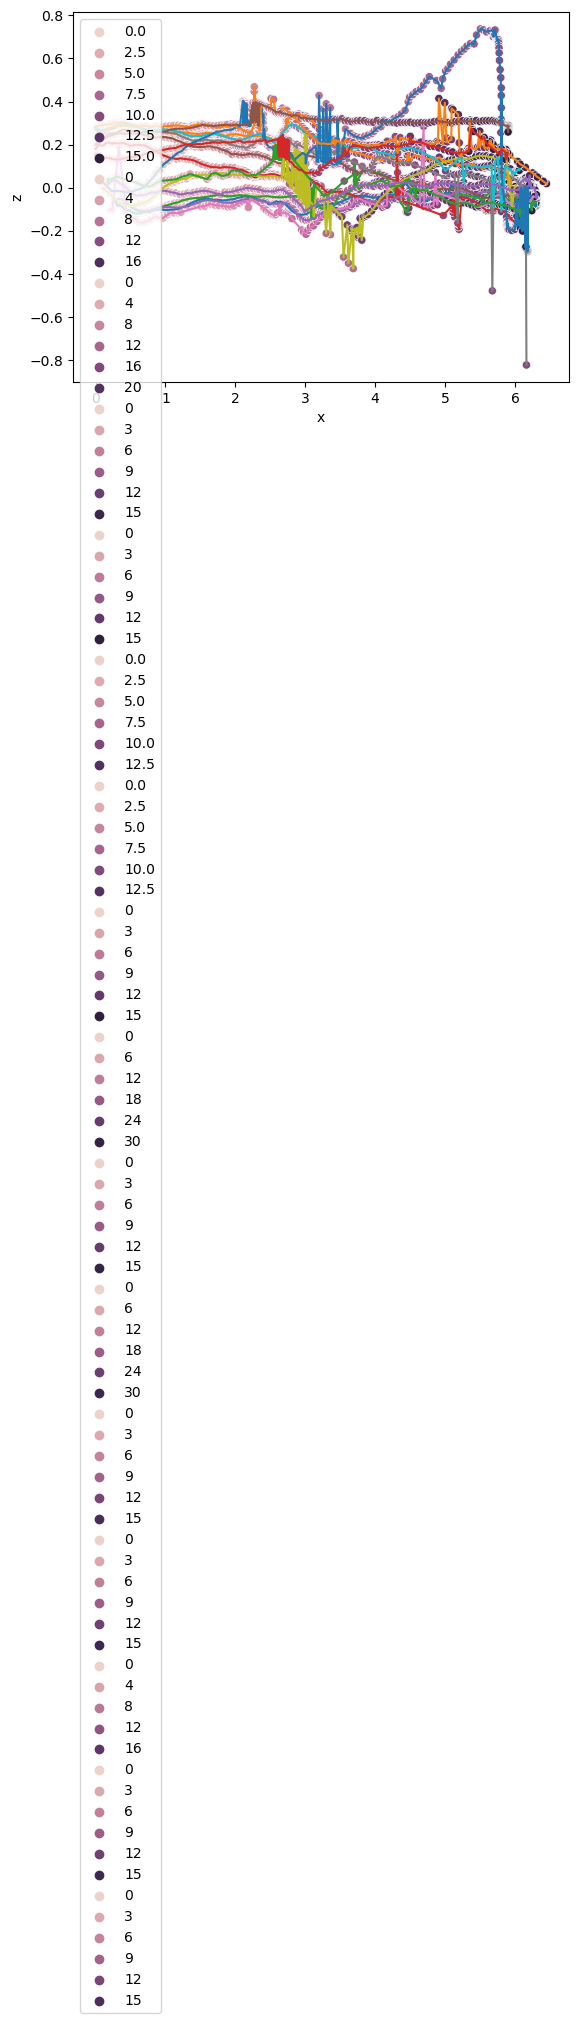

In [15]:
pp_id = '02'
position_of = 'Spot'

for i in range (1, 17):
    df_traj = pd.read_csv('./traj_data/id_' + pp_id + '/' + position_of + '/' + pp_id + '_' + str(i) + '.csv')
    print(df_traj)
    
    sns.scatterplot(data = df_traj.loc[: , ['x', 'z', 'time']], x = 'x', y = 'z', hue = 'time' )
    sns.lineplot(data = df_traj.loc[: , ['x', 'z', 'time']], x = 'x', y = 'z')
